In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from collections import defaultdict
from matplotlib.ticker import ScalarFormatter

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 8,
    "mathtext.fontset": "stix"
})

In [2]:
# Extract simulation data
file_path = '/Users/susannedahle/CellTypeDependenceElStim/simulation_data/plot_imem_data_ideal.npy' 
imem_data = np.load(file_path, allow_pickle=True).item()

In [3]:
# Make subset data dictionary for Im plots
target_freqs = [10, 100, 1000]

scatter_imem_data = {}

for cell_name, cell_data in imem_data.items():
    freqs = np.array(cell_data['freqs'])
    
    # Find indices corresponding to 10, 100, and 1000 Hz
    freq_indices = [np.argmin(np.abs(freqs - f)) for f in target_freqs]
    
    # Extract subsets
    imem_amps_subset = np.array(cell_data['imem_amps'])[:, freq_indices].tolist()
    imem_phases_subset = np.array(cell_data['imem_phases'])[:, freq_indices].tolist()
    pos_avg_subset = [cell_data['positive_avg_imem_pos'][i] for i in freq_indices]
    neg_avg_subset = [cell_data['negative_avg_imem_pos'][i] for i in freq_indices]
    cdm_pos_subset = [cell_data['cdm_pos'][i] for i in freq_indices]
    cdm_neg_subset = [cell_data['cdm_neg'][i] for i in freq_indices]
    
    # Build new dictionary for this cell
    scatter_imem_data[cell_name] = {
        'freqs': [freqs[i] for i in freq_indices],
        'x': cell_data['x'],
        'z': cell_data['z'],
        'totnsegs': cell_data['totnsegs'],
        'tvec': cell_data['tvec'],
        'imem_amps': imem_amps_subset,
        'imem_phases': imem_phases_subset,
        'cdm_pos': cdm_pos_subset,
        'cdm_neg': cdm_neg_subset
    }

In [4]:
def plot_imem_ideal(
        subset_imem_data,
        full_imem_data,
        xlim1=(None, -0.002),
        xlim2=(-4e-5, -1e-6),
        xlim3=(-1e-6, None)
    ):

    left_cells = subset_imem_data
    right_cells = full_imem_data

    unique_cells = list(left_cells.keys())
    num_cells = len(unique_cells)
    if num_cells == 0:
        print("No cells to plot.")
        return

    # ========================= FIGURE SETUP ==============================
    fig = plt.figure(figsize=(11, 3 * num_cells))
    main_gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1.8, 1], wspace=0.3)

    # -- LEFT PANEL: morphology + 3-way broken Im(t)
    gs_left = gridspec.GridSpecFromSubplotSpec(
        num_cells, 4, subplot_spec=main_gs[0, 0],
        width_ratios=[1, 1.2, 1.2, 1.2],
        wspace=0.3, hspace=0.5
    )

    axs_left_panel = {}

    for i, label in enumerate(unique_cells):
        ax_left = fig.add_subplot(gs_left[i, 1])
        ax_mid  = fig.add_subplot(gs_left[i, 2], sharey=ax_left)
        ax_right = fig.add_subplot(gs_left[i, 3], sharey=ax_left)

        axs_left_panel[label] = {
            'morph': fig.add_subplot(gs_left[i, 0]),
            'imem_left': ax_left,
            'imem_mid': ax_mid,
            'imem_right': ax_right,
        }

    colors_neurons = ['salmon', 'deepskyblue']
    colors_pz = ['firebrick', 'darkblue']
    colors_imem = ['tab:purple', 'tab:orange', 'tab:green']

    # ======================= MAIN CELL LOOP ==============================
    for i, (label, ax_dict) in enumerate(axs_left_panel.items()):

        # --------------------------- LOAD DATA ----------------------------
        cell_data = left_cells[label]
        x = np.array(cell_data['x'])
        z = np.array(cell_data['z'])
        totnsegs = cell_data['totnsegs']
        freqs = np.array(cell_data['freqs'])
        imem_amps = np.array(cell_data['imem_amps'])
        imem_phases = np.array(cell_data['imem_phases'])
        z_coords = z.mean(axis=-1)

        # ----------------------- A: MORPHOLOGY ---------------------------
        ax_m = ax_dict['morph']
        col = colors_neurons[i % len(colors_neurons)]

        for idx in range(totnsegs):
            ax_m.plot(x[idx], z[idx], c=col, lw=2)

        ax_m.plot(x.mean(axis=-1)[0], z.mean(axis=-1)[0], 'o', color='black', markersize=4)

        name = 'Long neuron' if 'BL_-500_UL_1000' in label else 'Short neuron'

        ax_m.set_xlim(-np.max(z) * 0.3, np.max(z) * 0.3)
        ax_m.set_title(name, fontsize=10, x=0.5, y=1.06)
        ax_m.set_aspect('equal')
        ax_m.set_xticks([])
        ax_m.set_frame_on(False)

        # ----------------------- B: SCATTER PLOTS -------------------------
        ax_left = ax_dict['imem_left']
        ax_mid  = ax_dict['imem_mid']
        ax_right = ax_dict['imem_right']

        soma_phases = imem_phases[0]

        cdm_phases = right_cells[label]['cdm_phases']
        t_max_dict_cdm = {}

        # time of inward Im for CDM
        for f_idx, f in enumerate(freqs):
            phase = cdm_phases[f_idx]
            t = (np.pi/2 - phase) / (2*np.pi*f)
            while t < 0:
                t += 1.0/f
            t_max_dict_cdm[f] = t

        # -------- scatter Im(t) into all three axes --------
        for f_idx, f in enumerate(freqs):

            chosen_t = t_max_dict_cdm[f]

            # accumulate Im(t) at each z
            z_imem_map = defaultdict(float)
            for seg_idx in range(totnsegs):
                amp = imem_amps[seg_idx][f_idx]
                phi = imem_phases[seg_idx][f_idx]
                curr = amp * np.sin(2*np.pi*f*chosen_t + phi)
                z_imem_map[z_coords[seg_idx]] += curr

            z_vals = list(z_imem_map.keys())
            im_vals = list(z_imem_map.values())

            marker, ms, alpha = (
                ('o', 25, 1) if f == 10 else
                ('x', 10, 1) if f == 100 else
                ('^', 10, 1)
            )

            # plot into all 3
            for ax in (ax_left, ax_mid, ax_right):
                ax.scatter(im_vals, z_vals,
                           color=colors_imem[f_idx], marker=marker, s=ms, alpha=alpha, label = f'{f} Hz')

        # vertical line in rightmost axis
        ax_mid.axvline(0, color='black', linestyle=':')

        # -------------------- AXIS LIMITS --------------------
        ax_left.set_xlim(xlim1)
        ax_mid.set_xlim(xlim2)
        ax_right.set_xlim(xlim3)

        # -------------------- FORMATTING ---------------------
        # left axis keeps y-labels
        ax_left.spines['right'].set_visible(False)
        ax_left.yaxis.tick_left()
        ax_left.set_ylabel('z [µm]')
        fmt_left = ScalarFormatter(useMathText=True)
        fmt_left.set_powerlimits((-1,1))
        ax_left.ticklabel_format(style='sci', axis='x')
        ax_left.xaxis.set_major_formatter(fmt_left)

        # mid axis no y-axis
        ax_mid.spines['left'].set_visible(False)
        ax_mid.spines['right'].set_visible(False)
        ax_mid.yaxis.set_visible(False)
        fmt_mid = ScalarFormatter(useMathText=True)
        fmt_mid.set_powerlimits((-1,1))
        ax_mid.ticklabel_format(style='sci', axis='x')
        ax_mid.xaxis.set_major_formatter(fmt_mid)

        # right axis no y-axis
        ax_right.spines['left'].set_visible(False)
        ax_right.yaxis.set_visible(False)
        fmt_right = ScalarFormatter(useMathText=True)
        fmt_right.set_powerlimits((-1,1))
        ax_right.ticklabel_format(style='sci', axis='x')
        ax_right.xaxis.set_major_formatter(fmt_right)

        # ------------------- BREAK MARKS ----------------------
        d = 0.015

        # left ↔ mid
        kwargs = dict(color='k', clip_on=False)
        # left side
        ax_left.plot((1 - d, 1 + d), (-d, +d),
                     transform=ax_left.transAxes, **kwargs)
        ax_left.plot((1 - d, 1 + d), (1 - d, 1 + d),
                     transform=ax_left.transAxes, **kwargs)
        # mid side
        ax_mid.plot((-d, +d), (-d, +d),
                    transform=ax_mid.transAxes, **kwargs)
        ax_mid.plot((-d, +d), (1 - d, 1 + d),
                    transform=ax_mid.transAxes, **kwargs)

        # mid ↔ right
        # mid
        ax_mid.plot((1 - d, 1 + d), (-d, +d),
                    transform=ax_mid.transAxes, **kwargs)
        ax_mid.plot((1 - d, 1 + d), (1 - d, 1 + d),
                    transform=ax_mid.transAxes, **kwargs)
        # right
        ax_right.plot((-d, +d), (-d, +d),
                      transform=ax_right.transAxes, **kwargs)
        ax_right.plot((-d, +d), (1 - d, 1 + d),
                      transform=ax_right.transAxes, **kwargs)

        if i == 0:
            ax_right.legend(loc='best', fontsize='small')

    # shared xlabel
    fig.text(0.40, -0.02, '$I_\\mathrm{m}(t=t_{\\max})$ [nA]', ha='center', fontsize=10)

    # =====================================================================
    #                         PANEL C (unchanged)
    # =====================================================================
    gs_right = gridspec.GridSpecFromSubplotSpec(
        num_cells, 1, subplot_spec=main_gs[0, 1], hspace=0.5
    )

    for i, label in enumerate(unique_cells):

        ax = fig.add_subplot(gs_right[i, 0])
        cell_data = right_cells[label]

        freqs = np.array(cell_data['freqs'])
        pos_avg = np.array(cell_data['positive_avg_imem_pos'])
        neg_avg = np.array(cell_data['negative_avg_imem_pos'])

        name = 'Long neuron' if 'BL_-500_UL_1000' in label else 'Short neuron'
        color = colors_neurons[0] if 'Long' in name else colors_neurons[1]

        ax.axhline(0, color='dimgray', linestyle=(0, (6,1)), linewidth=0.8)

        ax.plot(freqs, pos_avg, 'o:', color=color, label='$\\lambda_\\mathrm{AC}$ Above', markersize = 3)
        ax.plot(freqs, neg_avg, 'x--', color=color, label='$\\lambda_\\mathrm{AC}$ Below', markersize = 4)

        ax.set_xscale('log')
        ax.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.8)
        ax.grid(which='minor', linestyle=':', linewidth=0.3, alpha=0.8)

        lim = 1.3 * max(np.max(pos_avg), np.max(np.abs(neg_avg)))
        ax.set_ylim(-lim, lim)
        ax.set_title(name, fontsize=10)
        ax.set_ylabel('$\\lambda_\\mathrm{AC}$ [µm]', fontsize=11, color=color)
        ax.tick_params(axis='y', labelcolor=color)

        # twin axis: p_z
        ax2 = ax.twinx()

        fre = cell_data['freqs']
        cdm_amp = cell_data['cdm']
        cdm_phase = cell_data['cdm_phases']
        cdm_up = cell_data['cdm_pos']
        cdm_up_ph = cell_data['cdm_pos_phases']
        cdm_dn = cell_data['cdm_neg']
        cdm_dn_ph = cell_data['cdm_neg_phases']

        cdm_max = []
        cdm_pos = []
        cdm_neg = []
        for f_idx, f in enumerate(fre):
            t = (np.pi/2 - cdm_phase[f_idx])/(2*np.pi*f)

            cdm_max.append(cdm_amp[f_idx] * np.sin(2*np.pi*f*t + cdm_phase[f_idx]))
            cdm_pos.append(cdm_up[f_idx] * np.sin(2*np.pi*f*t + cdm_up_ph[f_idx]))
            cdm_neg.append(cdm_dn[f_idx] * np.sin(2*np.pi*f*t + cdm_dn_ph[f_idx]))

        colpz = colors_pz[i]

        ax2.plot(fre, cdm_max, 'v-', color=colpz, label='$p_z$ Tot', markersize = 3)
        ax2.plot(fre, cdm_pos, 'o:', color=colpz, label='$p_z$ Above', markersize = 3)
        ax2.plot(fre, cdm_neg, 'x--', color=colpz, label='$p_z$ Below', markersize = 4)

        ax2.set_ylabel('$p_z$ [nA$\cdot$µm]', fontsize=11, color=colpz)
        ax2.tick_params(axis='y', labelcolor=colpz)

        lim2 = 1.3 * max(np.max(cdm_pos), np.max(np.abs(cdm_neg)))
        ax2.set_ylim(-lim2, lim2)

        # combined legend
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2,
                  fontsize=6, loc='lower right', ncol=2, frameon=True)

    fig.text(0.77, -0.015, 'Frequency [Hz]', ha='center', fontsize=10)

    # Panel labels
    fig.text(0.10, 0.96, 'A', fontsize=12, fontweight='bold')
    fig.text(0.23, 0.96, 'B', fontsize=12, fontweight='bold')
    fig.text(0.63, 0.96, 'C', fontsize=12, fontweight='bold')

    fig.savefig("/Users/susannedahle/Documents/Master/Code/fig_pdfs/fig6.pdf", bbox_inches='tight')
    plt.show()


<>:252: SyntaxWarning: invalid escape sequence '\c'
<>:252: SyntaxWarning: invalid escape sequence '\c'
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_42820/1459234181.py:252: SyntaxWarning: invalid escape sequence '\c'
  ax2.set_ylabel('$p_z$ [nA$\cdot$µm]', fontsize=11, color=colpz)


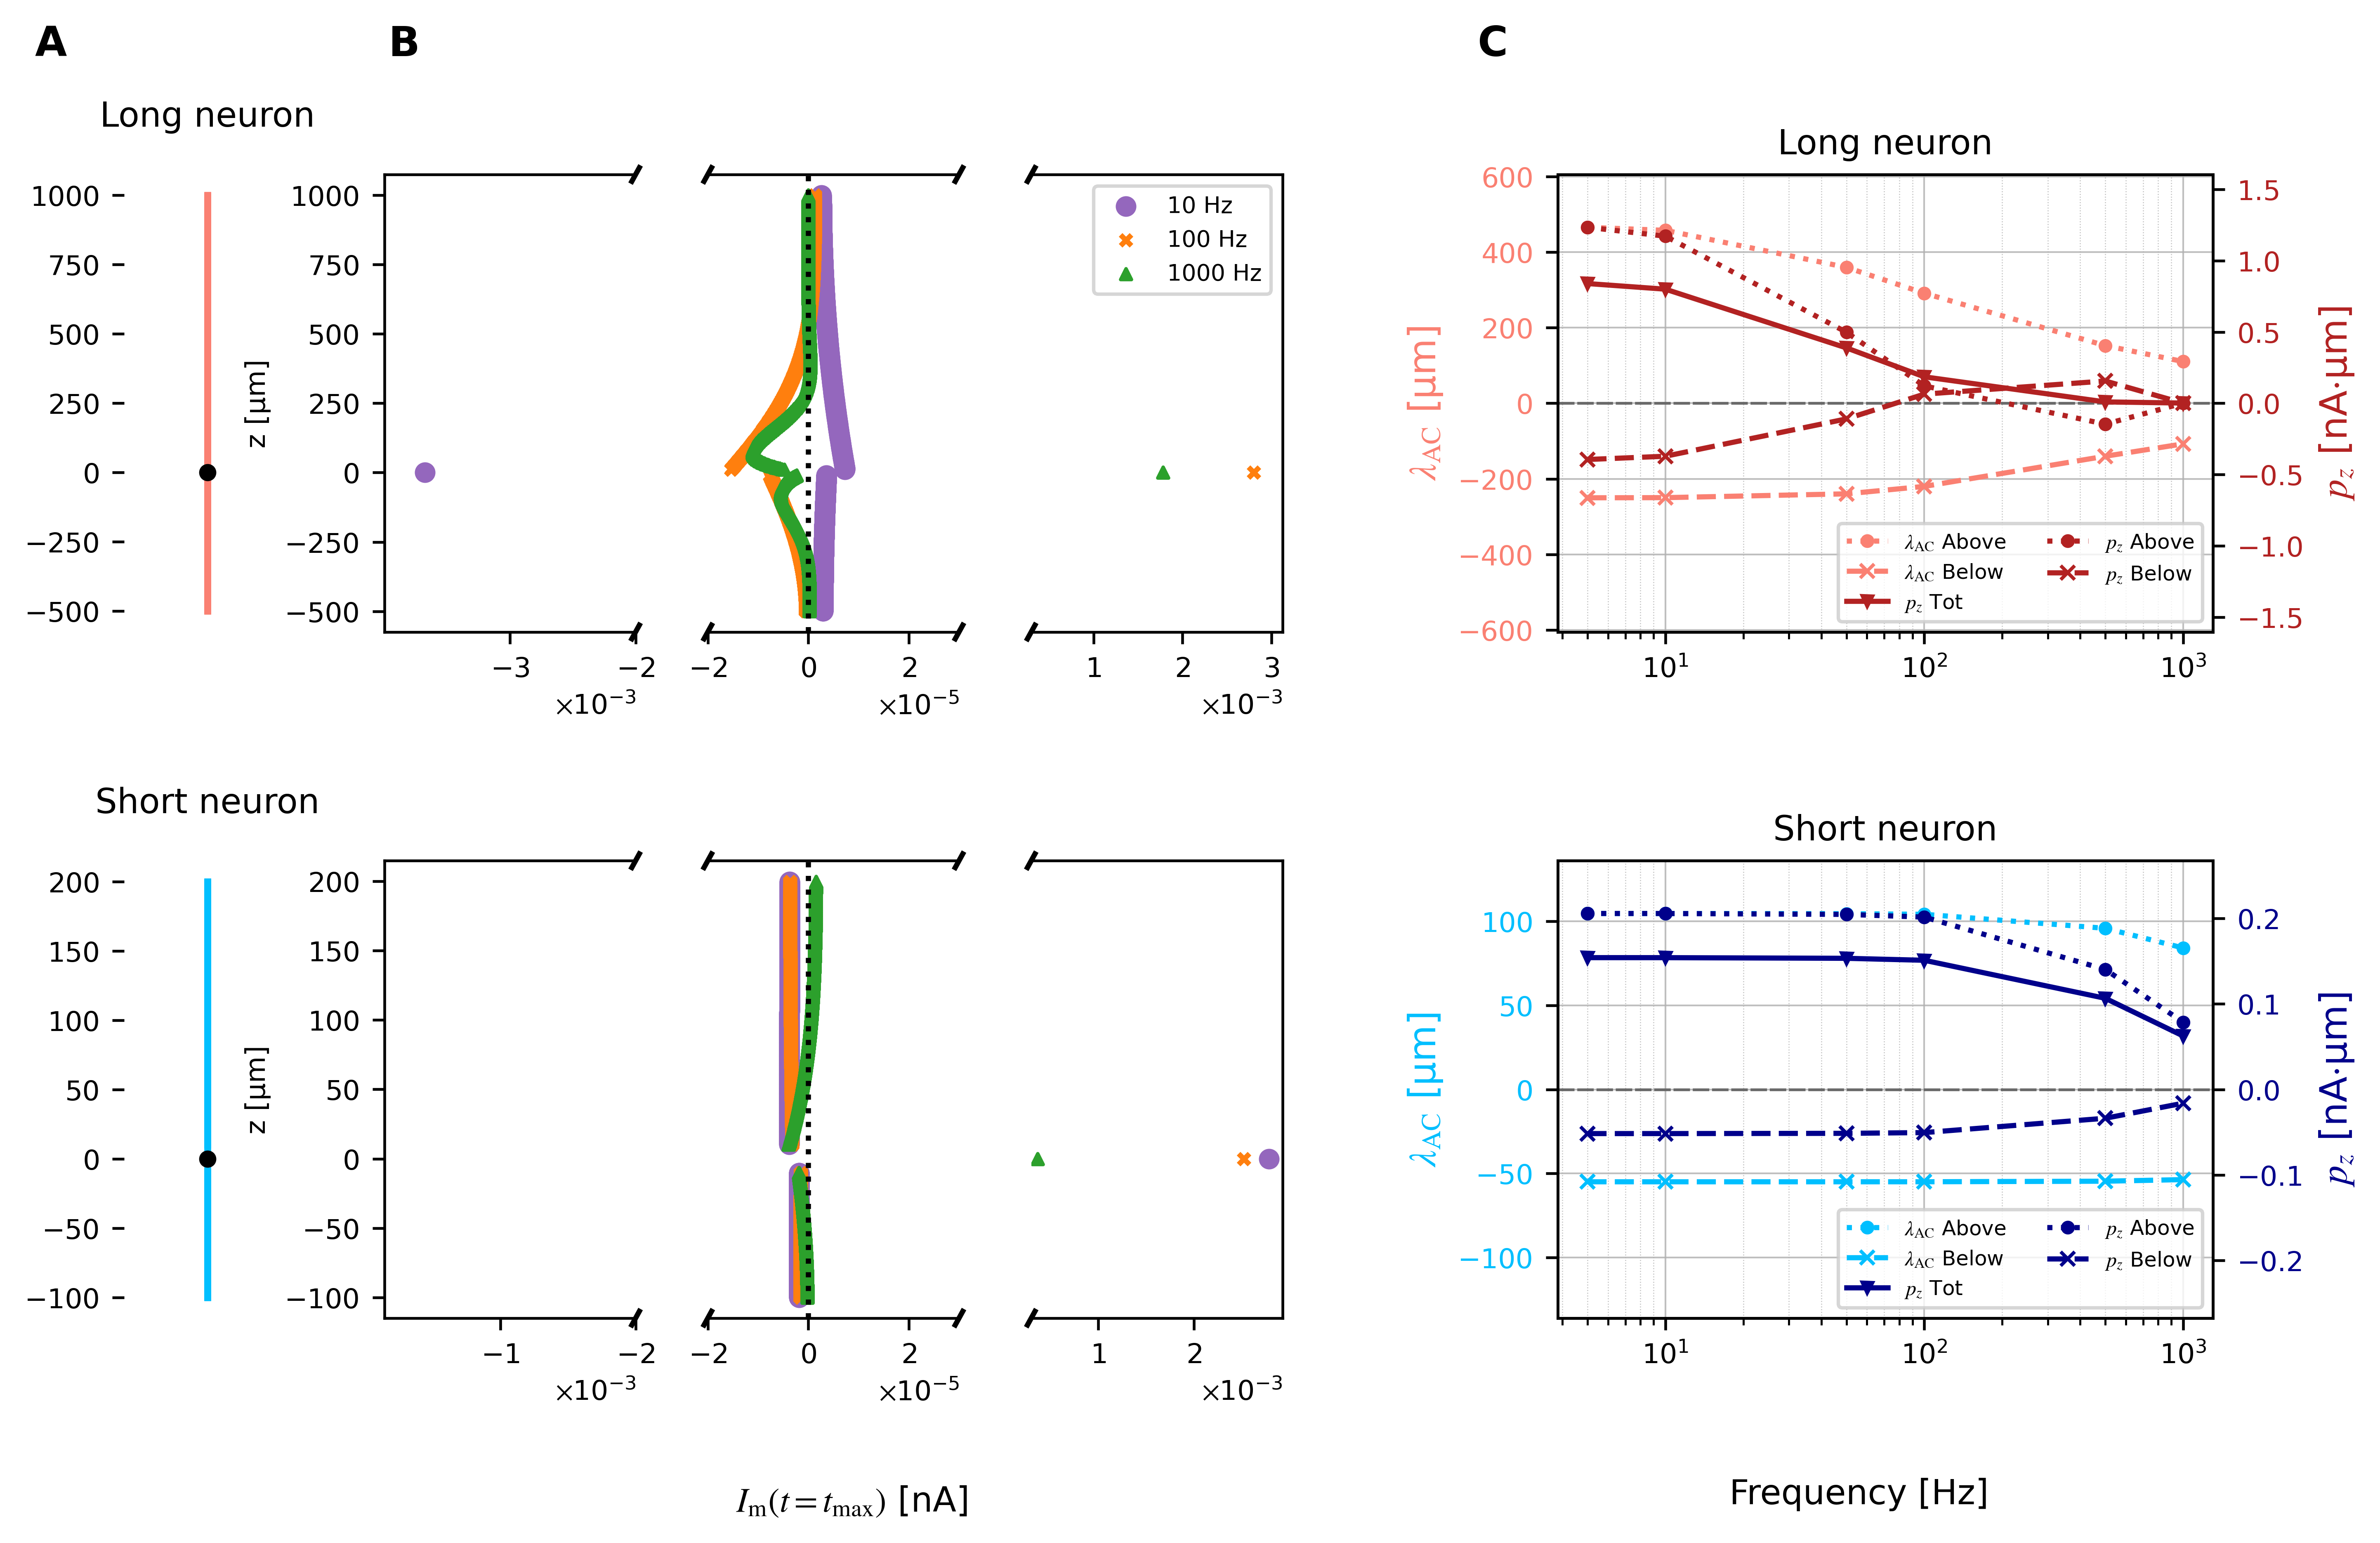

In [5]:
plot_imem_ideal(scatter_imem_data, imem_data, xlim1 = (None, -2e-3), xlim2 = (-2e-5, 3e-5), xlim3 = (3e-4, None))